In [3]:
!pip install gensim

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)


In [43]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from gensim.models import FastText

In [2]:
embeddings = pd.read_pickle("./data/clean_2020articles_w_title_embeddings.pkl")

In [5]:
embeddings = pd.read_csv("../data/metadata_w_2020articles_cleaned.csv", index_col=0)

In [6]:
embeddings

,uuid,source,year,article_text,title,title_text
0,bcbc6bb2-406e-11ee-a96e-33dec8f414a2,wp,2020,president trump on monday said he was “proud” ...,"trump shifts tone, says he’s ‘proud’ of fed am...","trump shifts tone, says he’s ‘proud’ of fed am..."
1,cfb4ce29-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in..."
2,db9f408f-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. forces have rescued an american citizen h...,us forces rescue american citizen held hostage...,us forces rescue american citizen held hostage...
3,e7b340f7-406e-11ee-a96e-33dec8f414a2,thehill,2020,president trump on tuesday evening blasted con...,"trump slams relief bill, calls on congress to ...","trump slams relief bill, calls on congress to ..."
4,a43934fc-411f-11ee-a96e-33dec8f414a2,thehill,2020,japanese tennis star naomi osaka has withdrawn...,naomi osaka withdraws from french open to focu...,naomi osaka withdraws from french open to focu...
...,...,...,...,...,...,...
37039,5d771a58-4136-11ee-a96e-33dec8f414a2,npr,2020,by \n npr staff\n \n \n ...,listen: 2020 republican national convention,listen: 2020 republican national convention by...
37040,b43dcf68-4135-11ee-a96e-33dec8f414a2,npr,2020,\n \n miles parks\n \n \n ...,new poll: americans overwhelmingly support vot...,new poll: americans overwhelmingly support vot...
37041,71b70f0c-4137-11ee-a96e-33dec8f414a2,npr,2020,\n \n rebecca hersher\n \n \n ...,biden to pick north carolina regulator michael...,biden to pick north carolina regulator michael...
37042,4303ccf8-4137-11ee-a96e-33dec8f414a2,npr,2020,by \n \n amita kelly\n \n \n ...,harris: 'you ushered in a new day for america',harris: 'you ushered in a new day for america'...


In [10]:
train, test = train_test_split(embeddings, test_size=0.5, random_state=42)


In [12]:
train.loc[:, 'source'].unique()

array(['washtimes', 'fox', 'dailycaller', 'breitbart', 'npr', 'bbc', 'wp'],
      dtype=object)

In [11]:
corpus = train.loc[:, 'title_text']
#corpus

In [28]:
# cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99)
# cv_matrix = cv.fit_transform(corpus)
# cv_matrix.shape

In [13]:
# tokenizing title docs
tokenized_docs = [doc.split() for doc in corpus]
ft_model = FastText(tokenized_docs, vector_size=512, window=20, min_count=2, 
                    workers=1, sg=1, seed=42, epochs=10)

In [14]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [15]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 512)
doc_vecs_ft.shape


(18522, 512)

In [12]:
# doc_vecs_ft[0]

In [5]:
train["bert_embeddings"] = train["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
train["np_embeddings"] = train["bert_embeddings"].apply(lambda x: x.numpy())
np_embedding = np.vstack(train["np_embeddings"])

In [6]:
np_embedding.shape[0]

22226

In [16]:
def ward_hierarchical_clustering(feature_matrix):
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_hierarchical_clusters(linkage_matrix, data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    titles = data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left",
                   truncate_mode='lastp',
                   p=p,
                   no_plot=True)
    temp = {R["leaves"][ii]: titles[ii] for ii in range(len(R["leaves"]))}

    def llf(xx):
        return "{}".format(temp[xx])

    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,
            leaf_label_func=llf,
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig(f'./data/bert_hierachical_clusters_num_docs_{data.shape[0]}_level_{p}.png', dpi=200)

In [9]:
bert_linkage_matrix = ward_hierarchical_clustering(np_embedding)

In [18]:
fast_text_linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

In [19]:
# plot_hierarchical_clusters(bert_linkage_matrix,
#                            p=10,
#                            data=train,
#                            figure_size=(18, 30))

In [20]:
# plot_hierarchical_clusters(bert_linkage_matrix,
#                            p=100,
#                            data=train,
#                            figure_size=(18, 30))

In [13]:
# This actually assigns a cluster number to each item depending on a certain cutoff point
# using a distance of 15 would give us 27 clusters!!
fcluster(bert_linkage_matrix, 20, criterion='distance').max()

233

In [12]:
fcluster(bert_linkage_matrix, 0.3, criterion='distance')

array([ 1701,  1663, 19423, ..., 12209,  7661,  7582], dtype=int32)

In [ ]:
# TODO map cluster numbers back to articles in training set and doo topic analysis

In [23]:
bert_linkage_matrix.shape

(22225, 4)

In [22]:
np_embedding.shape

(22226, 768)

In [26]:
len(train)

22226

In [21]:
# train['linkage_matrix'] = bert_linkage_matrix

In [22]:
backup = train.copy()
backup.head()

,uuid,source,year,article_text,title,title_text
28662,3c8cf1e0-406e-11ee-a96e-33dec8f414a2,washtimes,2020,russian surveillance aircraft flew into an are...,norad tracks russian aircraft flying...,norad tracks russian aircraft flying...
31727,3d1925a8-406a-11ee-a96e-33dec8f414a2,fox,2020,presumptive democratic presidential nominee jo...,conservative catholics call on biden to break ...,conservative catholics call on biden to break ...
4829,68fcf7b9-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,former vice president joe biden’s 2020 preside...,‘we’re playing offense’: biden campaign launch...,‘we’re playing offense’: biden campaign launch...
32959,2d900fc0-406a-11ee-a96e-33dec8f414a2,fox,2020,white house: president trump and the coronavir...,trump says coronavirus 'peak in death rate' li...,trump says coronavirus 'peak in death rate' li...
10037,b032682c-411f-11ee-a96e-33dec8f414a2,breitbart,2020,new zealand health minister david clark called...,‘idiot’ kiwi health minister forgiven after be...,‘idiot’ kiwi health minister forgiven after be...


In [24]:
np.save('../data/title_text_28kdocs_fasttext_embedding_linkage_matrix.npy', fast_text_linkage_matrix)

In [ ]:
#train_df = train.copy()
# train_df = train_df.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings', 'cluster_id'], axis=1)
# train_df.head()

In [47]:
# train_df.to_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv') 

In [50]:
# test_train_df = pd.read_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv', index_col=0)
# test_train_df.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [51]:
# Extracting cluster information
# clusters = {}
# for i, merge in enumerate(bert_linkage_matrix):
#     cluster_id = i + len(train)  # Cluster IDs start from len(X) and increment
#     left_child = int(merge[0])
#     right_child = int(merge[1])
#     distance = merge[2]
#     clusters[cluster_id] = {'left': left_child, 'right': right_child, 'distance': distance}

# for cluster_id, info in clusters.items():
#     left_row = train.iloc[info['left']]
#     right_row = train.iloc[info['right']]
#     print(f"Cluster {cluster_id}: Left Row - {left_row}, Right Row - {right_row}")

In [48]:
train_cluster_assignments = train.copy()
# train_cluster_assignments = train_cluster_assignments.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings'], axis=1)
distance_options = [0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 200]
for opt in distance_options:
    cluster_assignment = fcluster(fast_text_linkage_matrix, opt, criterion='distance')
    print(f'dist: {opt} num_clusters: {cluster_assignment.max()}')
    train_cluster_assignments[f'cluster_dist_{opt}'] = cluster_assignment
    

dist: 0.5 num_clusters: 18377
dist: 1 num_clusters: 18359
dist: 2 num_clusters: 16990
dist: 3 num_clusters: 8711
dist: 4 num_clusters: 4522
dist: 5 num_clusters: 2741
dist: 10 num_clusters: 667
dist: 20 num_clusters: 201
dist: 50 num_clusters: 44
dist: 100 num_clusters: 13
dist: 150 num_clusters: 6
dist: 200 num_clusters: 4


In [49]:
def compute_silhouette(orig_data, linkage_matrix, distance):
    labels = fcluster(linkage_matrix, distance, criterion='distance')
    silhouette_avg = silhouette_score(orig_data, labels)
    return silhouette_avg

sil_scores = []
for opt in distance_options:
    sil_score = compute_silhouette(doc_vecs_ft, fast_text_linkage_matrix, opt)
    sil_scores.append(sil_score)

# Print silhouette scores for different distance cutoffs
for cutoff, score in zip(distance_options, sil_scores):
    print(f"Distance cutoff: {cutoff}, Silhouette Score: {score}")

Distance cutoff: 0.5, Silhouette Score: 0.015412975664142872
Distance cutoff: 1, Silhouette Score: 0.01604598031749556
Distance cutoff: 2, Silhouette Score: 0.019821479975504926
Distance cutoff: 3, Silhouette Score: -0.007214562733636069
Distance cutoff: 4, Silhouette Score: -0.022782449990393305
Distance cutoff: 5, Silhouette Score: -0.030434753552586763
Distance cutoff: 10, Silhouette Score: -0.04505462804448108
Distance cutoff: 20, Silhouette Score: -0.05200463605667168
Distance cutoff: 50, Silhouette Score: -0.048868137117133476
Distance cutoff: 100, Silhouette Score: -0.0545594098406696
Distance cutoff: 150, Silhouette Score: -0.04844961079984806
Distance cutoff: 200, Silhouette Score: -0.05481857039944034


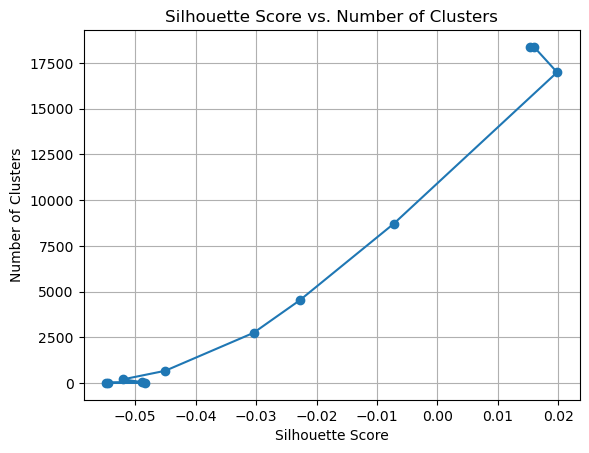

In [74]:
num_clusters = [18377,18359, 16990, 8711, 4522, 2741, 667, 201, 44, 13, 6, 4]
plt.plot(sil_scores, num_clusters, marker='o')
plt.xlabel('Silhouette Score')
plt.ylabel('Number of Clusters')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
train_cluster_assignments

In [61]:
# train_cluster_assignments.to_csv('./data/bert_22kdocs_cluster_assignments.csv') 

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [57]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meganmoore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meganmoore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

In [59]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

In [95]:
tfidf_scores_by_cluster = {}
cluster_sizes = {}
for clust_id in list(train_cluster_assignments.loc[:, 'cluster_dist_4'].unique()):
    clust_df = train_cluster_assignments.loc[train_cluster_assignments.loc[:, 'cluster_dist_4'] == clust_id, :]
    cluster_sizes[clust_id] = clust_df.shape[0]
    clust_text = clust_df.loc[:, 'title'].values
    tfidf_matrix = tfidf_vectorizer.fit_transform(clust_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0)
    tfidf_scores_by_cluster[clust_id] = [(feature_names[col], tfidf_scores[0, col]) for col in tfidf_matrix.nonzero()[1]]

In [96]:
top_words_by_cluster = {}
for cluster_id, scores in tfidf_scores_by_cluster.items():
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    unique_sorted_data = []
    seen_tuples = set()
    for key, value in sorted_scores:
        if value not in seen_tuples:
            unique_sorted_data.append((key, value))
            seen_tuples.add(value)
    top_words_by_cluster[cluster_id] = unique_sorted_data[:10]# sorted_scores[:10]  # Select top N words

In [73]:
# for cluster_id, top_words in top_words_by_cluster.items():
#     print(f"Cluster {cluster_id}:")
#     for word, score in top_words:
#         print(f"- {word}: {score}")

In [97]:
sorted_data = sorted(cluster_sizes.items(), key=lambda x: x[1])

In [98]:
sorted_data[-10:]

[(228, 14),
 (267, 14),
 (974, 14),
 (1744, 15),
 (536, 15),
 (719, 15),
 (1249, 15),
 (310, 16),
 (523, 17),
 (306, 18)]

In [100]:
# biggest clusters are 2, 8, 80, 3 & 6
biggest_clusters = sorted_data[-10:]
top_words = []
count_docs = []
for keyval, count in biggest_clusters:
    print(f'top words for cluster {keyval} with {count} articles: \n')
    for val in top_words_by_cluster[keyval][0:5]:
        print(val)
    count_docs.append(count)
    top_words.append("_".join([word[0] for word in top_words_by_cluster[keyval][0:5]]))
    print()
   


top words for cluster 228 with 14 articles: 

('coronavirus', 1.8409896682053084)
('china', 0.9354168290001765)
('wuhan', 0.7588523900678812)
('left', 0.7094438403299056)
('virus', 0.6572945468199987)

top words for cluster 267 with 14 articles: 

('trump', 1.9750153118266662)
('coronavirus', 1.2908901481468453)
('house', 1.2058391931734433)
('white', 1.0086147237974998)
('says', 0.9555930546705239)

top words for cluster 974 with 14 articles: 

('coronavirus', 1.5736358826701236)
('000', 0.7475910617904584)
('government', 0.7296393518608686)
('lockdowns', 0.7143090973347498)
('deaths', 0.5832272424766539)

top words for cluster 1744 with 15 articles: 

('trump', 2.067687237648446)
('biden', 1.6365263076295933)
('news', 1.149917842915038)
('fox', 1.0694712735722252)
('donald', 1.0147321014853834)

top words for cluster 536 with 15 articles: 

('biden', 1.8975751257344051)
('joe', 1.6066387060113625)
('trump', 1.1272539863007809)
('mate', 0.9561764011453948)
('pence', 0.6797159147323089

In [101]:
top_words

['coronavirus_china_wuhan_left_virus',
 'trump_coronavirus_house_white_says',
 'coronavirus_000_government_lockdowns_deaths',
 'trump_biden_news_fox_donald',
 'biden_joe_trump_mate_pence',
 'coronavirus_relief_senate_package_bill',
 'police_portland_protesters_watch_wisconsin',
 'biden_trump_election_says_2020',
 'trump_biden_coronavirus_buttigieg_press',
 'trump_biden_joe_donald_campaign']

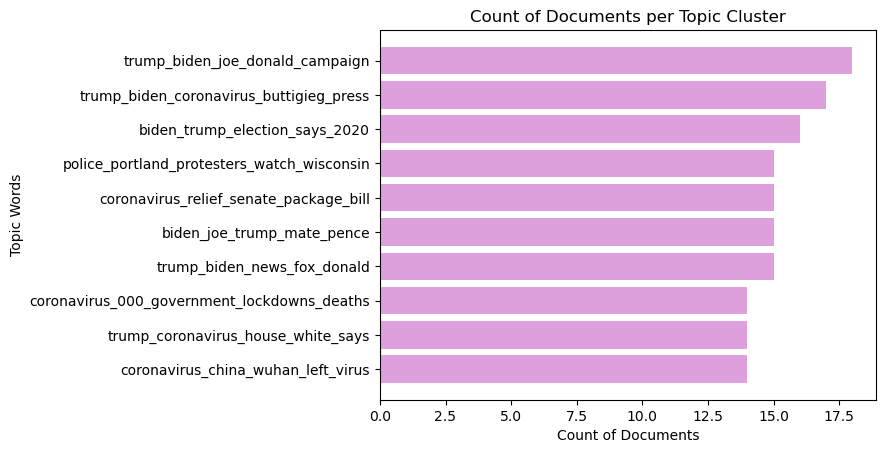

In [102]:
# Create bar plot
plt.barh(top_words, count_docs, color='plum')
plt.xlabel('Count of Documents')
plt.ylabel('Topic Words')
plt.title('Count of Documents per Topic Cluster')
plt.show()

In [ ]:
num_clusters = [18377,18359, 16990, 8711, 4522, 2741, 667, 201, 44, 13, 6, 4]
plt.plot(distance_options, num_clusters, marker='o')
plt.xlabel('Distance Cutoff')
plt.ylabel('Number of Clusters')
plt.title('Distance Cutoff vs. Number of Clusters')
plt.grid(True)
plt.show()